https://geektutu.com/post/tensorflow2-gym-dqn.html

## 20.3 用TensorFlow实现 DQN算法
1、游戏环境  
	这里使用gym为游戏环境，gym是OpenAI推出的免费的强化学习实验环境，支持Python语言。gym拥有多种环境，从简单到复杂，如经典的Acrobot机器人系统（Acrobot-v1）、小车爬山（MountaiCar-v0）、倒立摆摆动（Pendulum-v0）。此外，还包括2D和3D机器人等等。
本节将使用其中小车爬山（MountaiCar-v0）。　　
	gym库的安装比较简单，用pip安装即可：pip install gym
	gym库的使用方法是：用env=gym.make(环境名)加载环境，用env.reset()初始化环境，用env.step(动作)执行一个动作，用env.render()显示环境，用env.close()关闭环境。  
2、游戏规则  
	本节以小车爬山为游戏场景，如图20-9所示。向左/向右推动小车，小车若到达山顶，则游戏胜利，若200回合后，没有到达山顶，则游戏失败。每走一步得-1分，最低分-200，越早到达山顶，则分数越高。状态由[小车位置，小车速度]构成。动作为0表示向左推； 1表示不动； 2表示向右推。
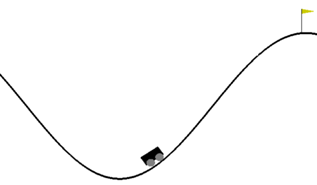
<center>图20-5 小车爬山游戏示意图</center>

3、更新Q表的表达式  
Q[s][a] = (1 - lr) * Q[s][a] + lr * (r + factor * max(Q[next_s]))
其中s表示状态，a表示动作，lr学习率，r表示奖励，factor表示折扣因子。  
4、用神经网络替换Q表，神经网络与环境（gym）、动作（a）、状态（s）、奖励（r）之间的关系，如图20-6所示。
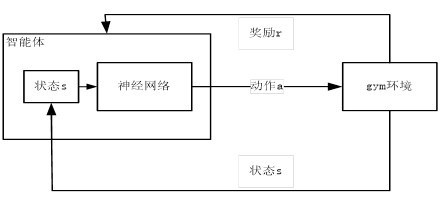
<center> 图20-6 神经网络与环境之间的交互关系</center>

## 详细实现代码如下

In [1]:
from collections import deque
import random
import gym
import numpy as np
from tensorflow.keras import models, layers, optimizers

## 设置一些超参数

In [2]:
#批量大小
batch_size=64
#学习率
lr=1
#更新Q值参数
factor=0.95
##确定状态维度
STATE_DIM=2
##确定动作向量维度
ACTION_DIM =3
#设置一些参数
episodes = 200  # 训练200次
score_list = []  # 记录所有分数

## 构建网络模型

In [3]:
class DQN(object):
    def __init__(self):
        self.step = 0
        self.update_freq = 200  # 模型更新频率
        self.replay_size = 2000  # 训练集大小
        self.replay_queue = deque(maxlen=self.replay_size)
        self.model = self.create_model()
        self.target_model = self.create_model()

    def create_model(self):
        """创建一个隐藏层为100的神经网络"""
        model = models.Sequential([
            layers.Dense(100, input_dim=STATE_DIM, activation='relu'),
            layers.Dense(ACTION_DIM, activation="linear")
        ])
        model.compile(loss='mean_squared_error',optimizer=optimizers.Adam(0.001))
        return model

    def act(self, s, epsilon=0.1):
        """预测动作"""
        # 刚开始时，加一点随机成分，产生更多的状态
        if np.random.uniform() < epsilon - self.step * 0.0002:
            return np.random.choice([0, 1, 2])
        return np.argmax(self.model.predict(np.array([s]))[0])
   
    def save_model(self, file_path='MountainCar-dqn.h5'):
        print('model saved')
        self.model.save(file_path)

    def remember(self, s, a, next_s, reward):
        """历史记录，position >= 0.4时给额外的reward，快速收敛"""
        if next_s[0] >= 0.4:
            reward += 1
        self.replay_queue.append((s, a, next_s, reward))

    #定义训练函数
    def train(self):
        if len(self.replay_queue) < self.replay_size:
            return
        self.step += 1
        # 每update_freq 步，将model 的权重赋值给 target_model
        if self.step % self.update_freq == 0:
            self.target_model.set_weights(self.model.get_weights())

        replay_batch = random.sample(self.replay_queue, batch_size)
        s_batch = np.array([replay[0] for replay in replay_batch])
        next_s_batch = np.array([replay[2] for replay in replay_batch])

        Q = self.model.predict(s_batch)
        Q_next = self.target_model.predict(next_s_batch)

        # 使用公式更新训练集中的Q值
        for i, replay in enumerate(replay_batch):
            _, a, _, reward = replay
            Q[i][a] = (1 - lr) * Q[i][a] + lr * (reward + factor * np.amax(Q_next[i]))
 
        # 传入网络进行训练
        self.model.fit(s_batch, Q, verbose=0)

In [4]:
#加载环境
env = gym.make('MountainCar-v0')
agent = DQN()
for i in range(episodes):
    #初始化环境
    s = env.reset()
    score = 0
    while True:
        a = agent.act(s)
        #在环境中执行一个动作
        next_s, reward, done, _ = env.step(a)
        agent.remember(s, a, next_s, reward)
        agent.train()
        score += reward
        s = next_s
        if done:
            score_list.append(score)
            print('episode:', i, 'score:', score, 'max:', max(score_list))
            break
    # 最后如果10次平均分大于 -160 时，停止并保存模型
    if np.mean(score_list[-10:]) > -160:
        agent.save_model()
        break
env.close()


episode: 0 score: -200.0 max: -200.0
episode: 1 score: -200.0 max: -200.0
episode: 2 score: -200.0 max: -200.0
episode: 3 score: -200.0 max: -200.0
episode: 4 score: -200.0 max: -200.0
episode: 5 score: -200.0 max: -200.0
episode: 6 score: -200.0 max: -200.0
episode: 7 score: -200.0 max: -200.0
episode: 8 score: -200.0 max: -200.0
episode: 9 score: -200.0 max: -200.0
episode: 10 score: -200.0 max: -200.0
episode: 11 score: -200.0 max: -200.0
episode: 12 score: -200.0 max: -200.0
episode: 13 score: -200.0 max: -200.0
episode: 14 score: -200.0 max: -200.0
episode: 15 score: -200.0 max: -200.0
episode: 16 score: -200.0 max: -200.0
episode: 17 score: -200.0 max: -200.0
episode: 18 score: -200.0 max: -200.0
episode: 19 score: -200.0 max: -200.0
episode: 20 score: -200.0 max: -200.0
episode: 21 score: -200.0 max: -200.0
episode: 22 score: -200.0 max: -200.0
episode: 23 score: -200.0 max: -200.0
episode: 24 score: -200.0 max: -200.0
episode: 25 score: -200.0 max: -200.0
episode: 26 score: -20

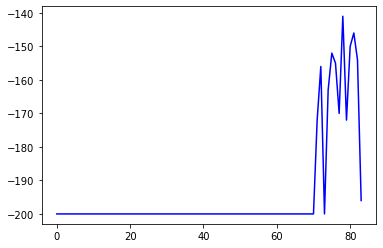

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(score_list, color='blue')
plt.show()

## 测试环境

In [7]:
import time

#恢复模型
model = models.load_model('MountainCar-dqn.h5')
s = env.reset()
score = 0
while True:
    #显示环境
    env.render()
    time.sleep(0.01)
    a = np.argmax(model.predict(np.array([s]))[0])
    s, reward, done, _ = env.step(a)
    score += reward
    if done:
        print('score:', score)
        break
env.close()

score: -177.0


测试时可看到小车运动界面：
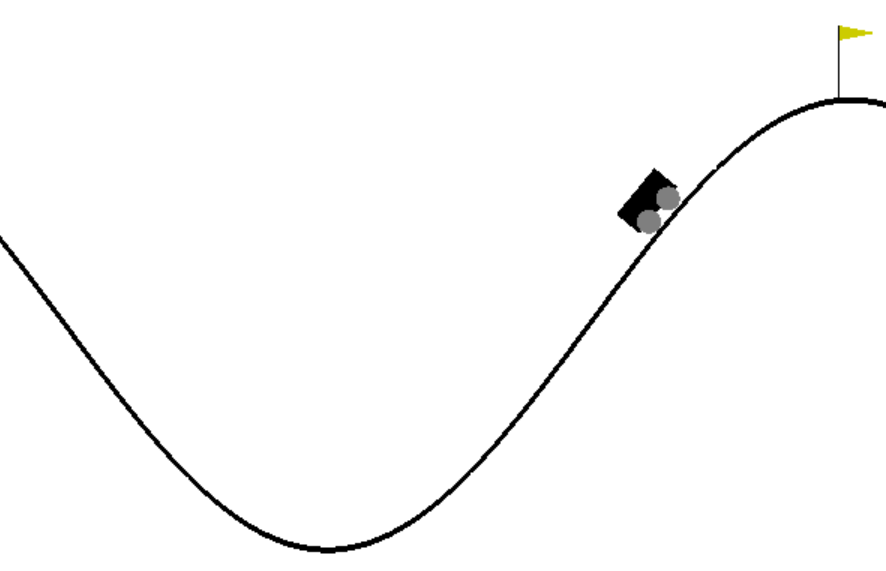